# Reconstruction error on synthetic data

In [1]:
CUDA_LAUNCH_BLOCKING=1

In [2]:
import os
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer.autoguide.guides import AutoNormal, AutoMultivariateNormal
import itertools
import torch
import random 


from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_blobs

/home/kdeazevedo/opt/anaconda3/envs/parafac/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7f7c66f50a50>


In [4]:
from parafac import models, synthetic, plots

In [5]:
def RMSELoss(yhat,y):
    '''
    Compute RMSE between two tensors
    '''
    return torch.sqrt(torch.mean((yhat-torch.nan_to_num(y))**2))

## Reconstruction error with fixed parameters

In [6]:
# Data and model parameters
R = 40
a = 1
b = 0.5
c = 1
d = 0.5
n_drugs = 5
n_patients = 20
n_features = 3000
n_views = 3
torch.manual_seed(0)
seeds = [0, 42, 2022]

In [7]:
def create_list_tensors(R, n_drugs, n_patients, n_features, seeds, n) :
    '''
    Create a list of Tensors from generated parse factor matrices
    R: int
        Rank
    n_drugs: int
        number of drugs, size of first dimension
    n_patients: int
        number of patients, size of second dimension
    n_features: int
        number of features, size of third dimension
    seeds: list
        list of random seeds for the generation of factords matrices
    n: int
        Number of views
    '''
    list_tensor = []
    # Create as many tensors as views
    for i in range(n):
        # Create shrinkages
        view_shrinkage = torch.distributions.HalfCauchy(torch.ones(1))
        rank_scale = torch.distributions.HalfCauchy(torch.ones(1))
        local_scale = torch.distributions.HalfCauchy(torch.ones(1))
        # We create three sparse matrices that serve as our factor matrices
        X1, cluster_labels = make_blobs(n_samples=n_patients, n_features=R, random_state=seeds[i], center_box=(-0.1,0.1))
        X2, cluster_labels = make_blobs(n_samples=n_drugs, n_features=R, random_state=seeds[i], center_box=(-0.1,0.1))
        X3, cluster_labels = make_blobs(n_samples=n_features, n_features=R, random_state=seeds[i], 
                                        center_box=(-0.1,0.1))
        A1 = torch.tensor(X1)
        A2 = torch.tensor(X2)
        A3 = torch.tensor(X3)
        new_tensor =  torch.einsum('ir,jr,kr->ijk', A1, A2, A3)
        # Add noise to the Tensor
        new_tensor_noisy =  torch.distributions.Normal(new_tensor, 1/torch.sqrt(torch.Tensor([1]))).sample()
        list_tensor.append(new_tensor_noisy)
    return list_tensor

In [8]:
list_tensor = create_list_tensors(R, n_drugs, n_patients, n_features, seeds, n_views)

In [9]:
obs_outcome = torch.Tensor(random.choices([0,1,2,3], k=20))

In [10]:
num_classes = 4
one_hot_encoding = torch.nn.functional.one_hot(obs_outcome.to(torch.int64), num_classes=num_classes)
one_hot_encoding = one_hot_encoding

In [11]:
seed = 123
n_epochs = 5000
n_features = [n_features]*n_views
n_views = len(n_features)
p = 4 # number of categories

# create an instance of the model
model = models.PARAFAC(
    list_tensor,
    n_features = n_features,
    outcome_obs = one_hot_encoding,
    p = p,
    R = R,
    use_gpu = True
)

device arg
None
self.device
cuda:3


In [12]:
# set random seed
pyro.set_rng_seed(seed)
# clean start
print("Cleaning parameter store")
pyro.enable_validation(True)
pyro.clear_param_store()

#run the model
loss_history, _ = model.fit(
    n_epochs=n_epochs,
    n_particles=1,
    learning_rate=0.001,
    optimizer="clipped",
    verbose=1,
    seed=seed
)

Cleaning parameter store
torch.Size([20, 5, 9000])


  0%|                                                                                   | 0/5000 [00:00<?, ?it/s]/home/kdeazevedo/opt/anaconda3/envs/parafac/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
100%|██████████████████████████████████████████████████████████| 5000/5000 [04:20<00:00, 19.17it/s, ELBO=3.77e+4]


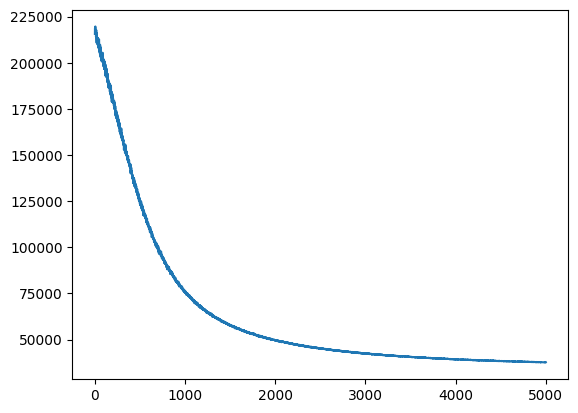

In [13]:
plt.plot(loss_history)

In [14]:
# Get posteriors
samples = model._guide.median()
A2_sample = samples["A2"].detach().cpu()
A1_sample = samples["A1"].detach().cpu()
A3_sample = samples["A3"].detach().cpu()
tau = samples["tau"].detach().cpu()
lmbda = samples["lmbda"].detach().cpu()

In [15]:
# The inferred tensor is not taken from the posterior, but multiplied from the inferred factor matrices
inferred_tensor = torch.einsum('ir,jr,kr->ijk', A1_sample, A2_sample, A3_sample)
inferred_tensor_with_noise = pyro.sample("Y", dist.Normal(torch.einsum('ir,jr,kr->ijk', A1_sample, A2_sample, A3_sample), 1/tau))

In [16]:
cat_tensor = torch.cat(list_tensor, 2)

In [17]:
RMSELoss(inferred_tensor_with_noise, torch.cat(list_tensor, 2))

tensor(7.8935, dtype=torch.float64)

In [18]:
trace = pyro.poutine.trace(model._model).get_trace(cat_tensor.cpu(), obs_outcome, ~torch.isnan(cat_tensor.cpu()))
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

ValueError: Error while computing log_prob at site 'outcome':
The right-most size of value must match event_shape: torch.Size([20]) vs torch.Size([4]).
      Trace Shapes:                 
       Param Sites:                 
      Sample Sites:                 
          rank dist           |     
              value        40 |     
           log_prob           |     
          view dist           |     
              value         3 |     
           log_prob           |     
        sample dist           |     
              value        20 |     
           log_prob           |     
        factor dist           |     
              value         5 |     
           log_prob           |     
       feature dist           |     
              value      9000 |     
           log_prob           |     
         class dist           |     
              value         4 |     
           log_prob           |     
           tau dist           |     
              value           |     
           log_prob           |     
view_shrinkage dist    3    1 |     
              value    3    1 |     
           log_prob    3    1 |     
    rank_scale dist    3   40 |     
              value    3   40 |     
           log_prob    3   40 |     
         lmbda dist        40 |     
              value        40 |     
           log_prob        40 |     
            A1 dist   20   40 |     
              value   20   40 |     
           log_prob   20   40 |     
            A2 dist    5   40 |     
              value    5   40 |     
           log_prob    5   40 |     
   local_scale dist 9000   40 |     
              value 9000   40 |     
           log_prob 9000   40 |     
            A3 dist 9000   40 |     
              value 9000   40 |     
           log_prob 9000   40 |     
       w_prior dist    4   40 |     
              value    4   40 |     
           log_prob    4   40 |     
       outcome dist   20    1 | 20 4
              value           | 20  

In [ ]:
pyro.render_model(model._model, model_args=(cat_tensor.cpu(), obs_outcome, ~torch.isnan(cat_tensor.cpu())), render_distributions=True)

In [ ]:
rank_scale = samples["rank_scale"].detach().cpu()
view_shrinkage = samples["view_shrinkage"]
local_scale = samples["local_scale"]
A1_infer = samples["A1"]
A2_infer = samples["A2"]

In [ ]:
rank_scale

In [ ]:
view_shrinkage

In [ ]:
sns.heatmap(rank_scale)

In [ ]:
X1, cluster_labels = make_blobs(n_samples=10, centers=2, n_features=20, random_state=0, cluster_std=1, center_box=(-0.1,0.1))
X2, cluster_labels = make_blobs(n_samples=10, centers=2, n_features=20, random_state=0, cluster_std=1, center_box=(-0.1,0.1))
A1 = torch.tensor(X1)
A2 = torch.tensor(X2)
A1_df = pd.DataFrame(A1)
A2_df = pd.DataFrame(A2)

In [ ]:
hist(A1_df)

In [ ]:
metadata = pd.DataFrame({"drug": cluster_labels,
                        "patients": list(np.arange(0,(10/2)))*2})

In [ ]:
metadata

In [ ]:
list_mat = [A1_df, A2_df]

In [ ]:
len(metadata.columns)

In [ ]:
len(set(list(metadata.drug)))

In [ ]:
list_mat[0]